In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.sparse import lil_matrix, csr_matrix
from sklearn.linear_model import Ridge
from nba_api.stats.static import players
from nba_api.stats.static import teams

# Update directory path
os.chdir('/Users/graallen/Documents/Personal Docs/Grad School/fall_2024/ds_785/capstone')
os.environ["GRB_LICENSE_FILE"] = 'gurobi.lic'

from import_lineups_final import lineups_df_raw, lineups_df

In [2]:
# only deal with data in the first 4 quarters and get rid of 1996
lineups_df_raw = lineups_df_raw[(lineups_df_raw['period']<=4) & (lineups_df_raw['season']>21997)]

# Identify games where unique_players does not equal 10
games_to_filter = lineups_df_raw[(lineups_df_raw['unique_players'] != 10) | (lineups_df_raw['points'] < 0)]['game'].unique()

# Filter out the identified games from the DataFrame
lineups_df_raw = lineups_df_raw[~lineups_df_raw['game'].isin(games_to_filter)]

### Average Stint Length

In [57]:
# Function to convert "minutes:seconds" to total seconds remaining in the period
def time_to_seconds(time_str):
    minutes, seconds = map(int, time_str.split(':'))
    return minutes * 60 + seconds

# Initialize dicts to track stints
stint_counts = {player_id: [] for player_id in nba_players_dict.keys()}
stint_lengths = {player_id: [] for player_id in nba_players_dict.keys()}

# Process each game
for (season, game), game_df in lineups_df_raw.groupby(['season', 'game']):
    # Update end_time and start_time based on period transitions
    for i in range(len(game_df) - 1):
        if game_df.iloc[i]['period'] != game_df.iloc[i + 1]['period']:
            game_df.at[game_df.index[i], 'end_time'] = '0:00'
    for i in range(1, len(game_df)):
        if game_df.iloc[i]['period'] != game_df.iloc[i - 1]['period']:
            game_df.at[game_df.index[i], 'start_time'] = '12:00'
    
    # Track stints for the current game
    home_stints = {player_id: [] for player_id in nba_players_dict.keys()}
    away_stints = {player_id: [] for player_id in nba_players_dict.keys()}
    
    for _, row in game_df.iterrows():
        start_seconds = time_to_seconds(row['start_time'])
        end_seconds = time_to_seconds(row['end_time'])
        stint_duration = start_seconds - end_seconds
        
        current_home_players = set(row['players'][:5])
        current_away_players = set(row['players'][5:])
        
        for player_id in current_home_players:
            home_stints[player_id].append(stint_duration)
        
        for player_id in current_away_players:
            away_stints[player_id].append(stint_duration)

    # Aggregate stint data
    for player_id, durations in home_stints.items():
        if durations:
            stint_counts[player_id].append(len(durations))
            stint_lengths[player_id].extend(durations)
    
    for player_id, durations in away_stints.items():
        if durations:
            stint_counts[player_id].append(len(durations))
            stint_lengths[player_id].extend(durations)

# Calculate average stint counts and lengths
average_stint_counts = [sum(counts) / len(counts) for counts in stint_counts.values() if counts]
average_stint_lengths = [sum(lengths) / len(lengths) for lengths in stint_lengths.values() if lengths]


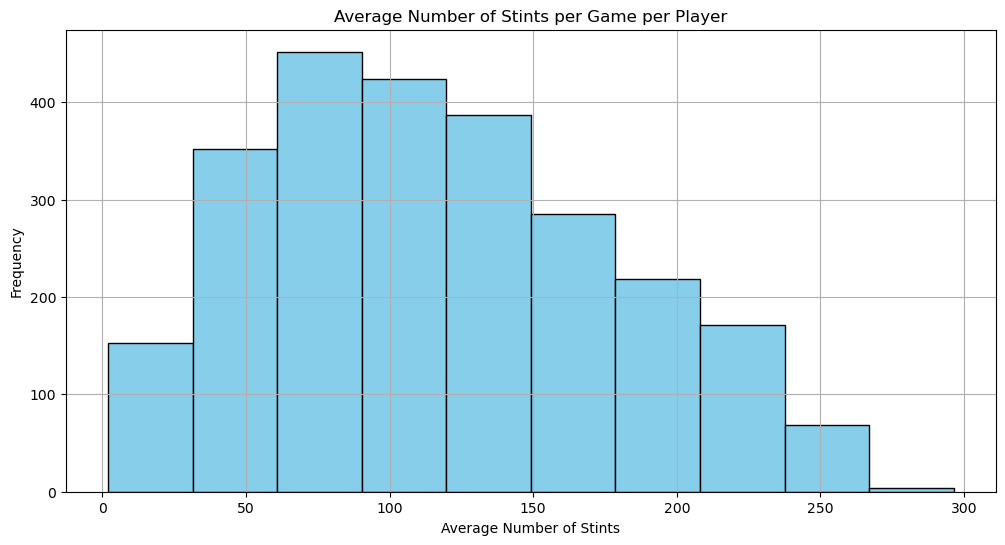

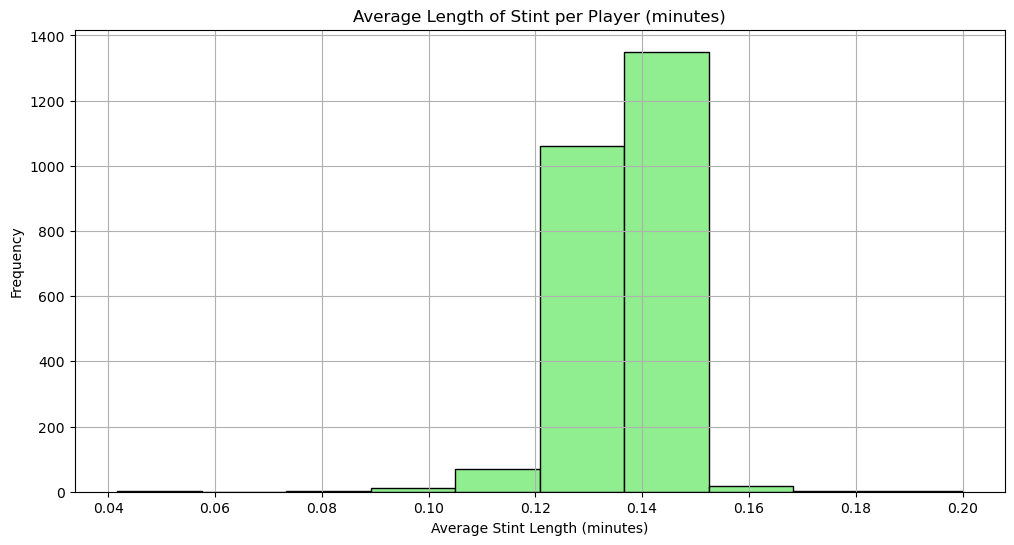

In [58]:
# Plot histograms
plt.figure(figsize=(12, 6))
plt.hist(average_stint_counts, bins=10, color='skyblue', edgecolor='black')
plt.title('Average Number of Stints per Game per Player')
plt.xlabel('Average Number of Stints')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.hist([length / 60 for length in average_stint_lengths], bins=10, color='lightgreen', edgecolor='black')
plt.title('Average Length of Stint per Player (minutes)')
plt.xlabel('Average Stint Length (minutes)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Average Rest Length

In [ ]:
# Function to convert "minutes:seconds" to total seconds remaining in the period
def time_to_seconds(time_str):
    minutes, seconds = map(int, time_str.split(':'))
    return minutes * 60 + seconds

# Initialize dictionaries to track rest periods
rest_periods = {player_id: [] for player_id in nba_players_dict.keys()}

# Process each game
for (season, game), game_df in df.groupby(['season', 'game']):
    # Update end_time and start_time based on period transitions
    for i in range(len(game_df) - 1):
        if game_df.iloc[i]['period'] != game_df.iloc[i + 1]['period']:
            game_df.at[game_df.index[i], 'end_time'] = '0:00'
    for i in range(1, len(game_df)):
        if game_df.iloc[i]['period'] != game_df.iloc[i - 1]['period']:
            game_df.at[game_df.index[i], 'start_time'] = '12:00'
    
    # Track stints for the current game
    player_stints = {player_id: [] for player_id in nba_players_dict.keys()}
    
    for _, row in game_df.iterrows():
        start_seconds = time_to_seconds(row['start_time'])
        end_seconds = time_to_seconds(row['end_time'])
        
        current_home_players = set(row['players'][:5])
        current_away_players = set(row['players'][5:])
        
        for player_id in current_home_players.union(current_away_players):
            player_stints[player_id].append((start_seconds, end_seconds))
    
    # Calculate rest periods
    for player_id, stints in player_stints.items():
        for i in range(1, len(stints)):
            # Calculate rest period as the time between the end of one stint and the start of the next
            rest_period = stints[i][0] - stints[i-1][1]
            rest_periods[player_id].append(rest_period)

# Calculate average rest periods
average_rest_periods = [sum(periods) / len(periods) for periods in rest_periods.values() if periods]

# Plot histogram
plt.figure(figsize=(12, 6))
plt.hist([period / 60 for period in average_rest_periods], bins=10, color='lightcoral', edgecolor='black')
plt.title('Average Rest Period per Player (minutes)')
plt.xlabel('Average Rest Period (minutes)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Team Actual Lineup Schedule Per Game

In [44]:
temp_df = lineups_df_raw[(lineups_df_raw['season']==22023) & (lineups_df_raw['game']=='0022300998')].reset_index(drop=True)

In [46]:
# Update end_time to '0:00' if the next row is a different period
for i in range(len(temp_df) - 1):
    if temp_df.loc[i, 'period'] != temp_df.loc[i + 1, 'period']:
        temp_df.loc[i, 'end_time'] = '0:00'

# Update start_time to '12:00' if the previous row is a different period
for i in range(1, len(temp_df)):
    if temp_df.loc[i, 'period'] != temp_df.loc[i - 1, 'period']:
        temp_df.loc[i, 'start_time'] = '12:00'

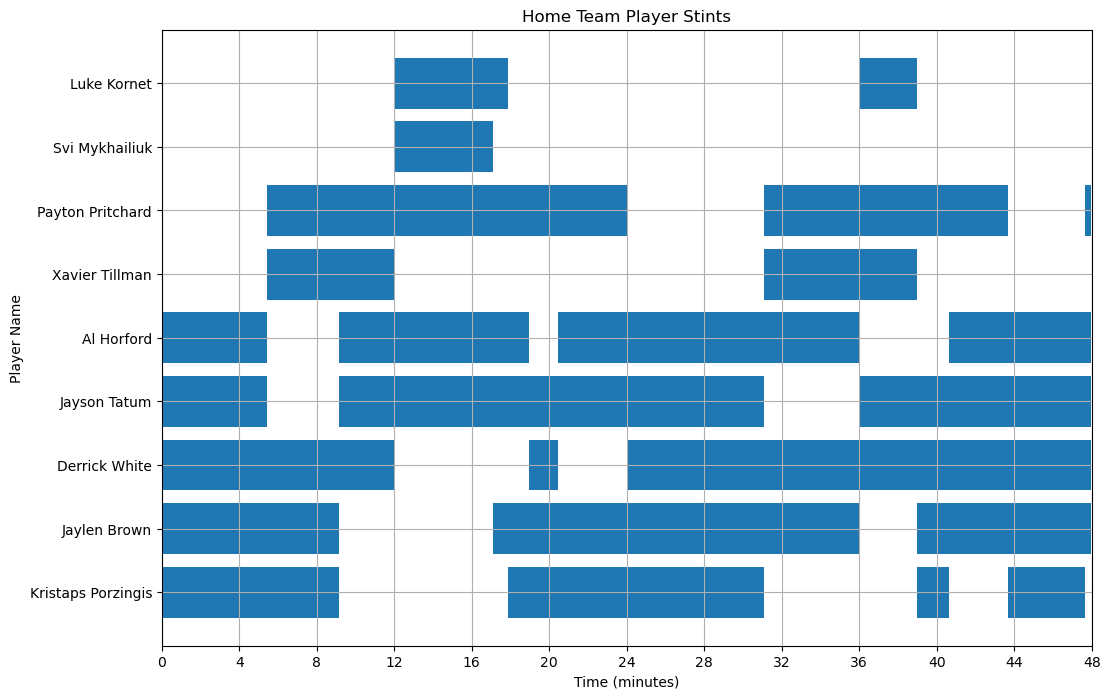

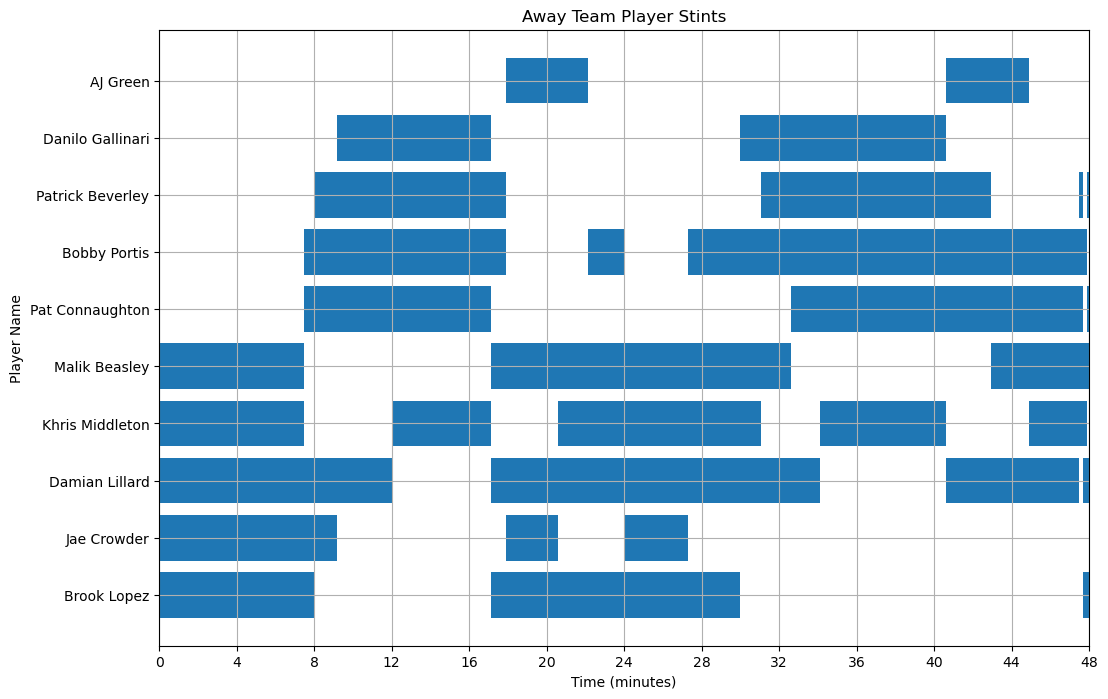

In [48]:
# Function to convert "minutes:seconds" to total seconds remaining in the period
def time_to_seconds(time_str):
    minutes, seconds = map(int, time_str.split(':'))
    return minutes * 60 + seconds

# Initialize dictionaries to track stints
home_stints = {}
away_stints = {}

# Initialize sets to track active players
active_home_players = set()
active_away_players = set()

# Iterate over each row to track player stints
for _, row in temp_df.iterrows():
    start_seconds = time_to_seconds(row['start_time'])
    end_seconds = time_to_seconds(row['end_time'])
    stint_duration = start_seconds - end_seconds
    
    # Current players on the court
    current_home_players = set(row['players'][:5])
    current_away_players = set(row['players'][5:])
    
    # Record stints for players who were on the court
    for player_id in current_home_players:
        if player_id not in home_stints:
            home_stints[player_id] = []
        home_stints[player_id].append((row['period'], start_seconds, stint_duration))
    
    for player_id in current_away_players:
        if player_id not in away_stints:
            away_stints[player_id] = []
        away_stints[player_id].append((row['period'], start_seconds, stint_duration))

# Function to plot Gantt chart for a team
def plot_gantt_chart(stints, title):
    fig, ax = plt.subplots(figsize=(12, 8))
    player_positions = {nba_players_dict[player_id]: idx for idx, player_id in enumerate(stints.keys())}
    
    for player_id, stints_list in stints.items():
        for period, start_seconds, duration in stints_list:
            start_time = (period - 1) * 12 * 60 + (12 * 60 - start_seconds)
            ax.broken_barh([(start_time / 60, duration / 60)], (player_positions[nba_players_dict[player_id]] - 0.4, 0.8), facecolors='tab:blue')
    
    ax.set_xlabel('Time (minutes)')
    ax.set_ylabel('Player Name')
    ax.set_title(title)
    ax.set_yticks(list(player_positions.values()))
    ax.set_yticklabels(list(player_positions.keys()))
    ax.set_xticks(range(0, 49, 4))  # Set x-ticks from 0 to 48, every 4 minutes
    ax.set_xlim(0, 48)  # Set x-axis limits from 0 to 48 minutes
    ax.grid(True)
    plt.show()

# Plot Gantt charts for home and away teams
plot_gantt_chart(home_stints, 'Home Team Player Stints')
plot_gantt_chart(away_stints, 'Away Team Player Stints')

In [56]:
# Function to convert "minutes:seconds" to total seconds remaining in the period
def time_to_seconds(time_str):
    minutes, seconds = map(int, time_str.split(':'))
    return minutes * 60 + seconds

# Initialize dictionaries to track stints
home_stints = {player_id: [] for player_id in nba_players_dict.keys()}
away_stints = {player_id: [] for player_id in nba_players_dict.keys()}

# Iterate over each row to track player stints
for _, row in temp_df.iterrows():
    start_seconds = time_to_seconds(row['start_time'])
    end_seconds = time_to_seconds(row['end_time'])
    stint_duration = start_seconds - end_seconds
    
    # Current players on the court
    current_home_players = set(row['players'][:5])
    current_away_players = set(row['players'][5:])
    
    # Record stints for players who were on the court
    for player_id in current_home_players:
        home_stints[player_id].append(stint_duration)
    
    for player_id in current_away_players:
        away_stints[player_id].append(stint_duration)

# Function to calculate total minutes played by each player
def calculate_total_minutes(stints):
    total_minutes = {nba_players_dict[player_id]: sum(durations) / 60 for player_id, durations in stints.items() if durations}
    return total_minutes

home_minutes = calculate_total_minutes(home_stints)
away_minutes = calculate_total_minutes(away_stints)

pd.DataFrame(list(home_minutes.items()), columns=['Player','Minutes'])

,Player,Minutes
0,Jaylen Brown,37.033333
1,Al Horford,38.166667
2,Luke Kornet,8.883333
3,Svi Mykhailiuk,5.116667
4,Kristaps Porzingis,27.966667
5,Payton Pritchard,31.466667
6,Jayson Tatum,39.350000
7,Xavier Tillman,14.466667
8,Derrick White,37.466667


### Functions for C-RAPM calculation

In [3]:
# Function to create a new dictionary with player IDs from the set and their MPG
def create_mpg_dict(player_ids, mpg_dict):
    return {(player_id): mpg for (player_id), mpg in mpg_dict.items() if player_id in player_ids}

# Function to calculate total SPM for a lineup
def calculate_player_spm(row, player_spm):
    season = row['season']
    lineup = row['lineup']
    
    # Fetch rapm values for each player in the lineup
    spm_values = [
        player_spm.loc[(player_spm['player_id'] == player_id) & (player_spm['season'] == season), 'spm'].values[0]
        for player_id in lineup
        if not player_spm.loc[(player_spm['player_id'] == player_id) & (player_spm['season'] == season), 'spm'].empty
    ]
    
    # Calculate the total SPM for the lineup
    return sum(spm_values)

In [4]:
def calculate_player_spm(row, player_spm):
    season = row['season']
    lineup = row['lineup']
    
    # Fetch rapm values for each player in the lineup
    spm_values = [
        player_spm.loc[(player_spm['player_id'] == player_id) & (player_spm['season'] == season), 'spm'].values[0]
        for player_id in lineup
        if not player_spm.loc[(player_spm['player_id'] == player_id) & (player_spm['season'] == season), 'spm'].empty
    ]
    
    # Calculate the total SPM for the lineup
    return sum(spm_values)

### Calculate overall parameters and split data into train and test

In [5]:
# Extract the last four digits of the game number
lineups_df['game_number'] = lineups_df['game'].astype(str).str[-4:].astype(int)

train_percentage = 0.8

# Function to split into train and test sets
def split_train_test(group, train_percentage):
    max_game_number = group['game_number'].max()
    train_threshold = int(max_game_number * train_percentage)
    train_set = group[group['game_number'] <= train_threshold]
    test_set = group[group['game_number'] > train_threshold]
    return train_set, test_set

# Group by season and apply the split function
train_sets = []
test_sets = []

for _, group in lineups_df.groupby('season'):
    train_set, test_set = split_train_test(group, train_percentage)
    train_sets.append(train_set)
    test_sets.append(test_set)

# Concatenate the train and test sets
train_df = pd.concat(train_sets).reset_index(drop=True)
test_df = pd.concat(test_sets).reset_index(drop=True)

### Get the best model for our lineup plus-minus estimates

In [6]:
player_spm = pd.read_csv("best_model_predictions.csv")
player_spm['spm'] = player_spm['ospm'] + player_spm['dspm']
# lineup_model = pd.read_csv("lineup_rapm.csv")

In [7]:
# Precompute RAPM dictionaries
spm_dict = {
        'ospm': player_spm.set_index(['player_id', 'season'])['ospm'].to_dict(),
        'dspm': player_spm.set_index(['player_id', 'season'])['dspm'].to_dict()
    }

### Get all of the lineups by team and season

In [8]:
# Get the player and team names
nba_players = players.get_players()
nba_players = pd.DataFrame(nba_players)

nba_teams = teams.get_teams()
nba_teams = pd.DataFrame(nba_teams)

# Create a dictionary from the nba_players and nba_teams DataFrame for quick lookup
nba_players_dict = nba_players.set_index('id')['full_name'].to_dict()
nba_teams_dict = nba_teams.set_index('id')['abbreviation'].to_dict()

# Function to get player names from the lineup tuple
def get_player_names(lineup):
    return [nba_players_dict[player_id] for player_id in lineup]

def get_team_names(team_id):
    return nba_teams_dict[team_id]

In [9]:
lineups_df['home_lineup'] = lineups_df['players'].apply(lambda x: tuple(sorted(x[:5])))
lineups_df['away_lineup'] = lineups_df['players'].apply(lambda x: tuple(sorted(x[5:])))

# Create stats for home lineups
home_lineups = lineups_df.groupby(['season','home_team','home_lineup','home_possession']).agg(
    possessions=('game_possession', 'size'),
    points=('points', 'sum')
).reset_index()
home_lineups = home_lineups.pivot_table(index=['season', 'home_team', 'home_lineup'], columns='home_possession', values=['possessions','points']).reset_index()
home_lineups.columns.name = None
home_lineups.columns = ['season', 'home_team', 'home_lineup', 'home_points_against', 'home_points_for', 'home_possessions_against', 'home_possessions_for']

# Create stats for away lineups
away_lineups = lineups_df.groupby(['season','away_team','away_lineup','home_possession']).agg(
    possessions=('game_possession', 'size'),
    points=('points', 'sum')
).reset_index()

away_lineups = away_lineups.pivot_table(index=['season', 'away_team', 'away_lineup'], columns='home_possession', values=['possessions','points']).reset_index()
away_lineups.columns.name = None
away_lineups.columns = ['season', 'away_team', 'away_lineup', 'away_points_for', 'away_points_against', 'away_possessions_for', 'away_possessions_against']

# let's look at points per possession for a specific lineup at home vs. away - do we see the same trend
nba_lineups = pd.merge(home_lineups, away_lineups, how='outer', left_on=['season','home_team','home_lineup'], right_on=['season','away_team','away_lineup'])

# Create the lineup column based on home_lineup and away_lineup
nba_lineups['lineup'] = nba_lineups.apply(
    lambda row: row['home_lineup'] if pd.notna(row['home_lineup']) else row['away_lineup'], axis=1
)

# Create the team column based on home_team and away_team
nba_lineups['team_id'] = nba_lineups.apply(
    lambda row: row['home_team'] if pd.notna(row['home_team']) else row['away_team'], axis=1
)

# Drop the home_lineup and away_lineup columns 
nba_lineups = nba_lineups.drop(columns=['home_lineup', 'away_lineup'])
nba_lineups = nba_lineups.drop(columns=['home_team', 'away_team'])

# fill all the NaN values up to now with 0
nba_lineups = nba_lineups.fillna(0)

# Create new total columns based on home and away splits
nba_lineups['total_possessions_for'] = nba_lineups['home_possessions_for'] + nba_lineups['away_possessions_for']
nba_lineups['total_possessions_against'] = nba_lineups['home_possessions_against'] + nba_lineups['away_possessions_against']
nba_lineups['total_points_for'] = nba_lineups['home_points_for'] + nba_lineups['away_points_for']
nba_lineups['total_points_against'] = nba_lineups['home_points_against'] + nba_lineups['away_points_against']
nba_lineups['home_ppp_for'] = nba_lineups['home_points_for']/nba_lineups['home_possessions_for']
nba_lineups['home_ppp_against'] = nba_lineups['home_points_against']/nba_lineups['home_possessions_against']
nba_lineups['away_ppp_for'] = nba_lineups['away_points_for']/nba_lineups['away_possessions_for']
nba_lineups['away_ppp_against'] = nba_lineups['away_points_against']/nba_lineups['away_possessions_against']
nba_lineups['total_ppp_for'] = nba_lineups['total_points_for']/nba_lineups['total_possessions_for']
nba_lineups['total_ppp_against'] = nba_lineups['total_points_against']/nba_lineups['total_possessions_against']
nba_lineups['home_pm_p100'] = (nba_lineups['home_ppp_for']-nba_lineups['home_ppp_against'])*100
nba_lineups['away_pm_p100'] = (nba_lineups['away_ppp_for']-nba_lineups['away_ppp_against'])*100
nba_lineups['total_pm_p100'] = (nba_lineups['total_ppp_for']-nba_lineups['total_ppp_against'])*100

nba_lineups['team'] = nba_lineups['team_id'].apply(get_team_names)
nba_lineups = nba_lineups[['season','team_id','team','lineup','total_possessions_for']]

### Get box score data with game, player_id and minutes

In [10]:
# Get box score stats to get mpg for players so we can use that as a potential constraint for the model
player_box_stats = pd.read_csv("box_score_game_logs_1998_2023.csv")[['GAME_ID','TEAM_ID','TEAM_ABBREVIATION','PLAYER_ID','MIN']]
player_box_stats = player_box_stats.dropna(subset=['MIN'])

# Conversion function
def convert_to_decimal_minutes(value):
    minutes, seconds = map(float, value.split(':'))
    return minutes + seconds / 60

# Apply the conversion
player_box_stats['min'] = player_box_stats['MIN'].apply(convert_to_decimal_minutes)
player_box_stats['game'] = player_box_stats['GAME_ID'].apply(lambda x: f'00{x:06d}')
player_box_stats['team_id'] = player_box_stats['TEAM_ID']
player_box_stats['team'] = player_box_stats['TEAM_ABBREVIATION']
player_box_stats['player_id'] = player_box_stats['PLAYER_ID']

player_box_stats = player_box_stats[['game','team_id','team','player_id','min']]

In [11]:
# Function to calculate RAPM using precomputed dictionaries
def calculate_possession_spm(season, home_lineup, away_lineup, home_possession, spm_dict):
    ospm_dict = spm_dict['ospm']
    dspm_dict = spm_dict['dspm']
    
    if home_possession == 1:
        home_ospm = sum(ospm_dict.get((player, season), 0) for player in home_lineup)
        away_dspm = sum(dspm_dict.get((player, season), 0) for player in away_lineup)
        return home_ospm - away_dspm
    else:
        home_dspm = sum(dspm_dict.get((player, season), 0) for player in home_lineup)
        away_ospm = sum(ospm_dict.get((player, season), 0) for player in away_lineup)
        return home_dspm - away_ospm

In [12]:
# Function to calculate RAPM using precomputed dictionaries
def calculate_possession_home_spm(season, home_lineup, home_possession, spm_dict):
    ospm_dict = spm_dict['ospm']
    dspm_dict = spm_dict['dspm']
    
    if home_possession == 1:
        home_ospm = sum(ospm_dict.get((player, season), 0) for player in home_lineup)
        return home_ospm
    else:
        home_dspm = sum(dspm_dict.get((player, season), 0) for player in home_lineup)
        return home_dspm

In [13]:
# Function to calculate RAPM using precomputed dictionaries
def calculate_possession_away_spm(season, away_lineup, home_possession, spm_dict):
    ospm_dict = spm_dict['ospm']
    dspm_dict = spm_dict['dspm']
    
    if home_possession == 1:
        away_dspm = sum(dspm_dict.get((player, season), 0) for player in away_lineup)
        return away_dspm
    else:
        away_ospm = sum(ospm_dict.get((player, season), 0) for player in away_lineup)
        return away_ospm

### Loop through season, team and games to get the optimal lineups

In [14]:
from pyomo.environ import *
import time

seasons = [22023]
max_consecutive_minutes = 12
min_rest_minutes = 4

start_time = time.time()

In [ ]:
# Initialize lists to store results for all seasons
all_seasons_sim_results = []
all_seasons_comparison_results = []

# Loop through each season
for season_to_run in seasons:
    # Initialize lists to store results for all teams in the current season
    all_teams_sim_results = []
    all_teams_comparison_results = []

    # Loop through each team in nba_teams_dict
    for team_to_run in nba_teams_dict.keys():
        # Filter test_df for the current team and season
        team_df = test_df[((test_df['home_team'] == team_to_run) | (test_df['away_team'] == team_to_run)) & (test_df['season'] == season_to_run)].copy()
        team_lineups = nba_lineups[(nba_lineups['season'] == season_to_run) &
                                   (nba_lineups['team_id'] == team_to_run) &
                                   (nba_lineups['total_possessions_for'] > 0)].sort_values(by='total_possessions_for', ascending=False).reset_index(drop=True)
        team_lineups['lineup_id'] = team_lineups.index.to_series().apply(lambda x: f"lineup_{x}")

        team_df['home_lineup'] = team_df['players'].apply(lambda x: x[:5])
        team_df['away_lineup'] = team_df['players'].apply(lambda x: x[5:])

        # Calculate RAPM for each alpha and store in separate columns
        team_df['spm'] = team_df.apply(
            lambda row: calculate_possession_spm(
                row['season'], row['home_lineup'], row['away_lineup'], row['home_possession'], spm_dict
            ), axis=1
        )
        team_df['home_spm'] = team_df.apply(
            lambda row: calculate_possession_home_spm(
                row['season'], row['home_lineup'], row['home_possession'], spm_dict
            ), axis=1
        )
        team_df['away_spm'] = team_df.apply(
            lambda row: calculate_possession_away_spm(
                row['season'], row['away_lineup'], row['home_possession'], spm_dict
            ), axis=1
        )
        team_lineups['lineup_rating'] = team_lineups.apply(lambda row: calculate_player_spm(row, player_spm), axis=1)

        # Initialize a list to store simulation results for each game
        all_sim_results = []
        # Initialize a list to store comparison results
        comparison_results = []

        # Loop through games and calculate spm
        for game_id in team_df['game'].unique():
            print(f"Processing game {game_id} for team {team_to_run} in season {season_to_run}")
            game_data = team_df[team_df['game'] == game_id].reset_index(drop=True)

            # Calculate real performance metrics
            total_spm = game_data['spm'].sum()
            total_home_spm = game_data['home_spm'].sum()
            total_away_spm = game_data['away_spm'].sum()
            total_possessions = game_data['game_possession'].nunique() / 2

            # Retrieve player minutes for the game
            game_minutes = player_box_stats[(player_box_stats['game'] == game_id) & (player_box_stats['team_id'] == team_to_run)]
            mpg_dict = dict(zip(game_minutes['player_id'], game_minutes['min']))
            
            # update minutes to max mpg of any player on that team
            for key in mpg_dict:
                mpg_dict[key] = max(mpg_dict.values())

            # Filter team_lineups for players with > 0 minutes
            valid_lineups = team_lineups['lineup'].apply(lambda lineup: all(player in mpg_dict and mpg_dict[player] > 0 for player in lineup))
            filtered_lineups = team_lineups[valid_lineups].sort_values(by='total_possessions_for', ascending=False).reset_index(drop=True)

            df = filtered_lineups[['lineup_id', 'lineup_rating', 'lineup']].reset_index(drop=True)
            df = df.dropna()

            # Retry mechanism for solving the linear model
            solved = False
            current_min_rest_minutes = min_rest_minutes

            while not solved and current_min_rest_minutes >= 1:
                try:
                    # Run Linear Model
                    # Initialize the Pyomo model
                    model = ConcreteModel()

                    # Define sets for lineups and time slots
                    lineups = df['lineup_id'].tolist()
                    time_slots = range(48)  

                    # Define the plus-minus values and player groups and players
                    plus_minus_values = dict(zip(df['lineup_id'], df['lineup_rating']))
                    player_groups = dict(zip(df['lineup_id'], df['lineup']))
                    all_players = set([player for sublist in df['lineup'] for player in sublist])

                    # Define binary decision variables (whether a lineup is active in a time slot)
                    model.play_lineup = Var(lineups, time_slots, domain=Binary)

                    # Objective function: maximize total plus-minus across all chosen lineups in each time slot
                    model.objective = Objective(
                        expr=sum(model.play_lineup[lineup, slot] * plus_minus_values[lineup] for lineup in lineups for slot in time_slots),
                        sense=maximize
                    )

                    # Constraint: each time slot must have exactly one lineup
                    model.time_slot_constraint = Constraint(
                        time_slots,
                        rule=lambda model, slot: sum(model.play_lineup[lineup, slot] for lineup in lineups) == 1
                    )

                    # Constraint: Limit the total number of time slots a player can play
                    def max_total_minutes_rule(model, player):
                        max_minutes = np.ceil(mpg_dict[player]).astype(int)  # Get the max allowed slots for this player
                        return sum(
                            model.play_lineup[lineup, slot]
                            for slot in time_slots
                            for lineup in lineups if player in player_groups[lineup]
                        ) <= max_minutes

                    model.max_total_minutes_constraint = Constraint(all_players, rule=max_total_minutes_rule)

                    # Constraint: Limit the number of consecutive minutes a player can play
                    def max_consecutive_minutes_rule(model, player, slot):
                        if slot <= 47 - max_consecutive_minutes:
                            return sum(
                                model.play_lineup[lineup, slot + i] for i in range(max_consecutive_minutes + 1) for lineup in lineups if player in player_groups[lineup]
                            ) <= max_consecutive_minutes
                        return Constraint.Skip

                    model.max_consecutive_minutes_constraint = Constraint(all_players, time_slots, rule=max_consecutive_minutes_rule)

                    # Constraint: Require rest if player is subbed out
                    model.transition = Var(all_players, time_slots, domain=Binary)

                    def enforce_transition_rule(model, player, slot):
                        if slot < len(time_slots) - 1:
                            is_active_now = sum(
                                model.play_lineup[lineup, slot]
                                for lineup in lineups if player in player_groups[lineup]
                            )
                            is_active_next = sum(
                                model.play_lineup[lineup, slot + 1]
                                for lineup in lineups if player in player_groups[lineup]
                            )
                            return model.transition[player, slot] >= is_active_now - is_active_next
                        return Constraint.Skip

                    def enforce_rest_rule(model, player, slot):
                        if slot <= len(time_slots) - current_min_rest_minutes:
                            return sum(
                                model.play_lineup[lineup, slot + i]
                                for i in range(1, current_min_rest_minutes)
                                for lineup in lineups if player in player_groups[lineup]
                            ) <= (current_min_rest_minutes - 1) * (1 - model.transition[player, slot])
                        return Constraint.Skip

                    model.transition_rule = Constraint(all_players, time_slots, rule=enforce_transition_rule)
                    model.rest_rule = Constraint(all_players, time_slots, rule=enforce_rest_rule)

                    # Solve the problem
                    solver = SolverFactory('gurobi')
                    result = solver.solve(model, options={'TimeLimit': 5*60})

                    # Check if the solver found an optimal solution
                    if result.solver.termination_condition == TerminationCondition.optimal:
                        solved = True
                    else:
                        # If not optimal, decrement min_rest_minutes and retry
                        current_min_rest_minutes -= 1
                        print(f"Solver did not find an optimal solution for game {game_id} for team {team_to_run}. Decrementing rest minutes to {current_min_rest_minutes} and retrying...")
                        continue  # Skip to the next iteration of the while loop

                    if solved:
                        # Extract and store the results
                        optimal_schedule = {(lineup, slot): model.play_lineup[lineup, slot].value
                                            for lineup in lineups for slot in time_slots
                                            if model.play_lineup[lineup, slot].value > 0}

                        # Calculate total optimized plus-minus
                        total_optimized_spm = sum(plus_minus_values[lineup] for (lineup, slot), value in optimal_schedule.items())

                        # Store simulation data
                        sim_data = []
                        for (lineup, slot), value in optimal_schedule.items():
                            if value > 0:
                                sim_data.append({
                                    'season': season_to_run,  
                                    'team_id': team_to_run,
                                    'game_id': game_id,
                                    'minute': slot + 1,
                                    'lineup_id': lineup,
                                    'players': player_groups[lineup]
                                })
                        all_sim_results.append(pd.DataFrame(sim_data))

                        # Store comparison data
                        comparison_results.append({
                            'season': season_to_run,  
                            'team_id': team_to_run,
                            'game_id': game_id,
                            'total_spm': total_spm,
                            'total_home_spm': total_home_spm,
                            'total_away_spm': total_away_spm,
                            'total_possessions': total_possessions,
                            'optimized_spm_per_possession': (total_optimized_spm / 48) * 100,  # Assuming 48 minutes in a game
                            'used_min_rest_minutes': current_min_rest_minutes  # Store the min_rest_minutes used
                        })

                except Exception as e:
                    print(f"An error occurred while processing game {game_id} for team {team_to_run}: {e}")
                    current_min_rest_minutes -= 1
                    continue  # Skip to the next iteration of the while loop

            if not solved:
                print(f"Skipping game {game_id} for team {team_to_run} as no solution was found with min_rest_minutes reduced to 1.")

        # Combine all simulation results for the current team into a single DataFrame
        team_sim_results_df = pd.concat(all_sim_results, ignore_index=True)
        all_teams_sim_results.append(team_sim_results_df)

        # Create a DataFrame for comparison results for the current team
        team_comparison_results_df = pd.DataFrame(comparison_results)
        all_teams_comparison_results.append(team_comparison_results_df)

    # Combine results for all teams in the current season
    season_sim_results_df = pd.concat(all_teams_sim_results, ignore_index=True)
    all_seasons_sim_results.append(season_sim_results_df)

    season_comparison_results_df = pd.concat(all_teams_comparison_results, ignore_index=True)
    all_seasons_comparison_results.append(season_comparison_results_df)

# Combine results for all seasons
all_sim_results_df = pd.concat(all_seasons_sim_results, ignore_index=True)
all_comparison_results_df = pd.concat(all_seasons_comparison_results, ignore_index=True)

Processing game 0022300990 for team 1610612737 in season 22023
Processing game 0022301010 for team 1610612737 in season 22023
    containing a solution
Solver did not find an optimal solution for game 0022301010 for team 1610612737. Decrementing rest minutes to 3 and retrying...
Processing game 0022301021 for team 1610612737 in season 22023
Processing game 0022301034 for team 1610612737 in season 22023


In [ ]:
end_time = time.time()

elapsed_time = end_time - start_time

print("Elapsed time:", elapsed_time)

In [58]:
# need to pull in games and periods to get overtime games to exclude them
# Find all files matching the pattern
import glob
import pickle
file_list = glob.glob('lineup_dict_*.pkl')

def flatten_dict(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

def nested_dict_to_dataframe(nested_dict):
    rows = []
    for season, games in nested_dict.items():
        for game, game_data in games.items():
            base_info = {
                'season': season,
                'game': game,
                'home_team': game_data['home_team'],
                'away_team': game_data['away_team']
            }
            for play, plays_data in game_data['plays'].items():
                flat_dict = flatten_dict(plays_data)
                flat_dict.update(base_info)
                flat_dict['play'] = play
                rows.append(flat_dict)
    return pd.DataFrame(rows)

# Find all files matching the pattern
# file_list = glob.glob('/Users/graallen/Documents/Personal Docs/Grad School/fall_2024/ds_785/capstone/lineup_dict_*.pkl')

# Initialize an empty list to store DataFrames
lineups = []

# Iterate over the list of files
for file in file_list:
    with open(file, 'rb') as f:
        lineup_dict = pickle.load(f)
        
        # Convert the dictionary to a DataFrame (assuming the dictionary can be directly converted)
        df = nested_dict_to_dataframe(lineup_dict)
        
        # Append the DataFrame to the list
        lineups.append(df)

overtime_games = pd.concat(lineups, ignore_index=True)
overtime_games = overtime_games[overtime_games['period']>4]['game'].unique()

In [79]:
# Extract relevant columns from test_df
game_info = test_df[['game', 'home_team', 'away_team']].drop_duplicates()

# Merge game_info with all_comparison_results_df to determine home/away status
all_comparison_results_df2 = all_comparison_results_df.merge(
    game_info,
    left_on='game_id',
    right_on='game',
    how='left'
)

# Drop overtime games
all_comparison_results_df2 = all_comparison_results_df2[~all_comparison_results_df2['game_id'].isin(overtime_games)]

# Drop corrupted data games
games_to_filter = ['0022301009','0022301169','0022301168','0022301059']
all_comparison_results_df2 = all_comparison_results_df2[~all_comparison_results_df2['game_id'].isin(games_to_filter)]

# Add a new column to identify if the team was home or away
def determine_home_away(row):
    if row['team_id'] == row['home_team']:
        return 'home'
    elif row['team_id'] == row['away_team']:
        return 'away'
    else:
        return 'unknown'  # In case of any mismatch
all_comparison_results_df2['home_away'] = all_comparison_results_df2.apply(determine_home_away, axis=1)

# Drop the extra columns if not needed
all_comparison_results_df2.drop(columns=['home_team', 'away_team', 'game'], inplace=True)

# Add a new column 'team_name' to the DataFrame
all_comparison_results_df2['team_name'] = all_comparison_results_df2['team_id'].apply(lambda x: nba_teams_dict.get(x, 'None'))

# Create new columns based on the logic provided
all_comparison_results_df2['team_spm_actual'] = all_comparison_results_df2.apply(lambda row: row['total_home_spm'] if row['home_away'] == 'home' else row['total_away_spm'], axis=1)
all_comparison_results_df2['opponent_spm_actual'] = all_comparison_results_df2.apply(lambda row: row['total_away_spm'] if row['home_away'] == 'home' else row['total_home_spm'], axis=1)

# Rename columns
all_comparison_results_df2.rename(columns={
    'optimized_spm_per_possession': 'team_spm_optimized',
    'total_spm': 'total_spm_actual'
}, inplace=True)


# Adjust total_spm_actual based on home/away status
all_comparison_results_df2['total_spm_actual'] = all_comparison_results_df2.apply(lambda row: row['total_spm_actual'] if row['home_away'] == 'home' else -row['total_spm_actual'], axis=1)

# Calculate total_spm_optimized
all_comparison_results_df2['team_spm_optimized'] = (all_comparison_results_df2['team_spm_optimized']/100)*total_possessions

# Calculate total_spm_optimized
all_comparison_results_df2['total_spm_optimized'] = all_comparison_results_df2['team_spm_optimized'] - all_comparison_results_df2['opponent_spm_actual']

# Calculate model improvement
all_comparison_results_df2['model_improvement'] = all_comparison_results_df2['team_spm_optimized'] - all_comparison_results_df2['team_spm_actual']

# Add a 'game_number' column
all_comparison_results_df2 = all_comparison_results_df2.sort_values(by=['team_id', 'game_id'])
all_comparison_results_df2['game_number'] = all_comparison_results_df2.groupby('team_id').cumcount() + 1

# Reorder columns to match the desired order
all_comparison_results_df2 = all_comparison_results_df2[['team_id', 'team_name', 'game_id', 'game_number', 'home_away', 'team_spm_actual', 'team_spm_optimized', 
         'opponent_spm_actual', 'total_spm_actual', 'total_spm_optimized', 'model_improvement', 'total_possessions', 'used_min_rest_minutes']]

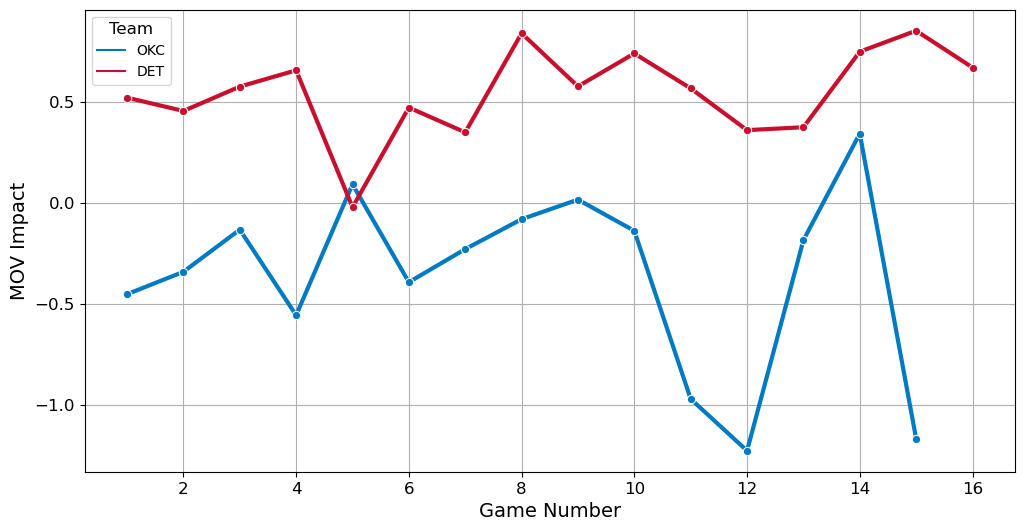

In [258]:
# Define a custom palette for the teams
custom_palette = {
    'DET': '#c8102e',
    'OKC': '#007ac1' 
}

# Filter the DataFrame for the two teams
teams_of_interest = all_comparison_results_df2[all_comparison_results_df2['team_name'].isin(['DET', 'OKC'])]

# Plot: Line graph with team_name as the legend
plt.figure(figsize=(12, 6))

sns.lineplot(
    data=teams_of_interest,
    x='game_number',
    y='model_improvement',
    hue='team_name',
    marker='o',
    markersize=6,
    linewidth=3,
    palette=custom_palette  # Use the custom palette
)

plt.xlabel('Game Number', fontsize=14)
plt.ylabel('MOV Impact', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(True)
plt.legend(title='Team', fontsize=10, title_fontsize=12)
plt.show()

In [91]:
# Create a dictionary for team colors
team_colors = {
    'DET': '#c8102e',
    'TOR': '#753bbd',
    'POR': '#e03a3e',
    'WAS': '#002b5c',
    'LAC': '#c8102e',
    'HOU': '#ba0c2f',
    'SAS': '#8a8d8f',
    'UTA': '#753bbd',
    'CHA': '#00778b',
    'MEM': '#5d76a9',
    'ORL': '#0077c0',
    'BKN': '#000000',
    'MIL': '#00471b',
    'SAC': '#5a2d81',
    'MIN': '#236192',
    'MIA': '#98002e',
    'NYK': '#f58426',
    'GSW': '#ffc72c',
    'CHI': '#ce1141',
    'PHI': '#006bb6',
    'ATL': '#e03a3e',
    'PHX': '#e56020',
    'DEN': '#418fde',
    'LAL': '#f9a01b',
    'CLE': '#860038',
    'BOS': '#007a33',
    'NOP': '#0c2340',
    'DAL': '#00538c',
    'IND': '#002d62',
    'OKC': '#007ac1' 
}

In [172]:
# Group by team_name and calculate the average of total_spm_actual and total_spm_optimized
avg_improvement = all_comparison_results_df2.groupby(['team_id','team_name'])[['model_improvement']].mean().sort_values(by='model_improvement',ascending=True).reset_index()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


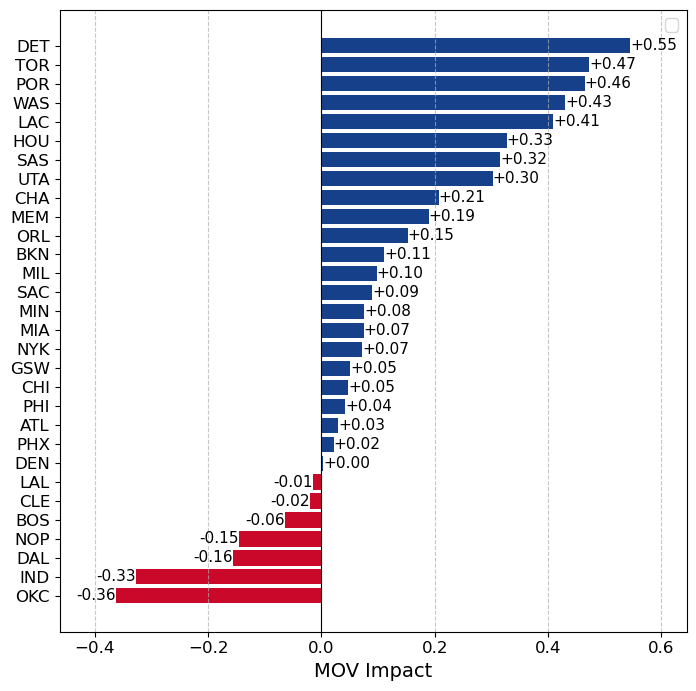

In [255]:
# Plot the horizontal bar chart
plt.figure(figsize=(7, 7))

# Colors for team
bars = plt.barh(avg_improvement['team_name'], avg_improvement['model_improvement'], color=[team_colors[team] for team in avg_improvement['team_name']])

# Colors for positive or negative
colors = ['#17408b' if x >= 0 else '#c9082a' for x in avg_improvement['model_improvement']]
bars = plt.barh(avg_improvement['team_name'], avg_improvement['model_improvement'], color=colors)


# Add labels to each bar
for bar, improvement in zip(bars, avg_improvement['model_improvement']):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
             f"{improvement:+.2f}", va='center', ha='left' if improvement >= 0 else 'right', fontsize=11)

# Set labels and title
# plt.ylabel('Team', fontsize=14)
plt.xlabel('MOV Impact', fontsize=14)

# Add a vertical line at x=0
plt.axvline(0, color='black', linewidth=0.8)

# Set x-axis limits
plt.xlim(min(avg_improvement['model_improvement']) - 0.1, max(avg_improvement['model_improvement']) + 0.1)

# Add gridlines
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.legend(fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)

# Show the plot
plt.show()

#### Get Winning % by team for 2023-24 season

In [160]:
# build API retry function to use for every npa_api call
def api_call_with_retries(api_class, retries=3, delay=10, **kwargs):
    for attempt in range(retries):
        try:
            api_instance = api_class(**kwargs)
            return api_instance
        except ReadTimeout as e:
            print(f"ReadTimeout occurred: {e}")
            if attempt < retries - 1:
                print(f"Retrying in {delay} seconds...")
                time.sleep(delay)
            else:
                print(f"Failed to retrieve data after {retries} attempts.")
                return None

In [169]:
from nba_api.stats.endpoints import leaguestandings
standings = api_call_with_retries(leaguestandings.LeagueStandings, season='2023-24')
standings = standings.get_data_frames()[0][['SeasonID','TeamID','WINS','LOSSES']]
standings.columns.name = None
standings.columns = ['season', 'team_id', 'wins', 'losses']
standings['win_pct'] = standings['wins'] / (standings['wins'] + standings['losses'])

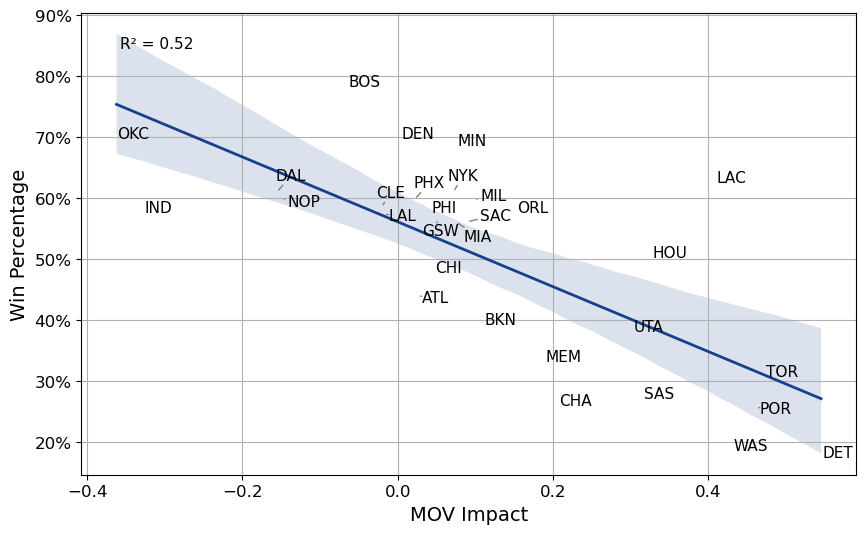

In [259]:
from adjustText import adjust_text
from matplotlib.ticker import FuncFormatter
    
# Merge the DataFrames on team_id
merged_df = pd.merge(avg_improvement, standings, on='team_id')

# Calculate linear regression and R-squared
X = merged_df['model_improvement'].values.reshape(-1, 1)
y = merged_df['win_pct'].values
reg = LinearRegression().fit(X, y)
r_squared = reg.score(X, y)

# Plot model_improvement vs. win_pct with regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='model_improvement', y='win_pct', data=merged_df, scatter=False, color='#17408b', line_kws={"linewidth": 2})

# Annotate points with team names and adjust text to prevent overlap
texts = []
for i, row in merged_df.iterrows():
    texts.append(plt.text(row['model_improvement'], row['win_pct'], row['team_name'], fontsize=11))

# Adjust text to prevent overlap
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'))

# Add R-squared annotation
plt.text(0.05, 0.95, f'R² = {r_squared:.2f}', transform=plt.gca().transAxes, fontsize=11, verticalalignment='top')

# Add labels and title
plt.xlabel('MOV Impact', fontsize=14)
plt.ylabel('Win Percentage', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)

# Format y-axis as percentage
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))

plt.grid(True)
plt.show()

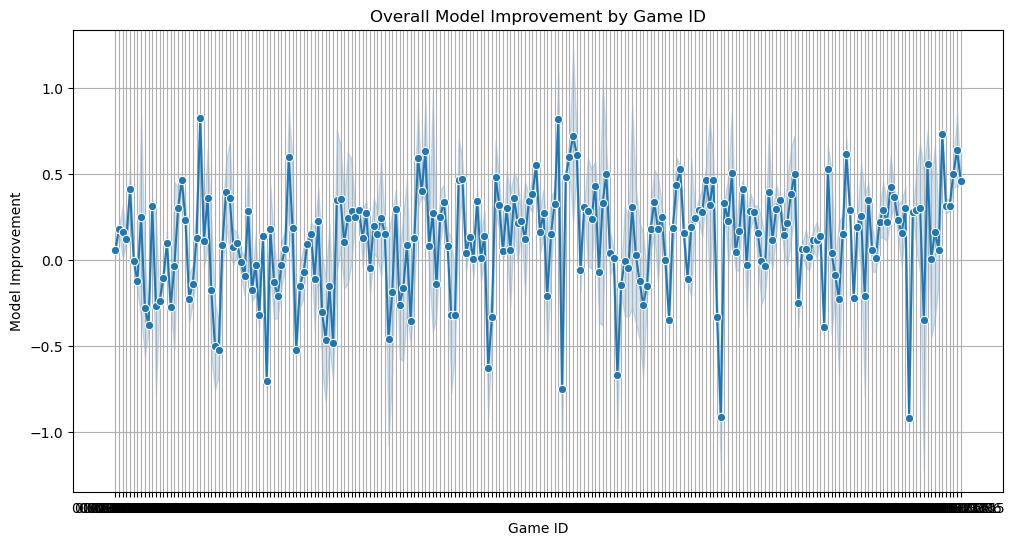

In [85]:
# Overall line graph of model improvement
plt.figure(figsize=(12, 6))
sns.lineplot(data=all_comparison_results_df2, x='game_id', y='model_improvement', marker='o')
plt.title('Overall Model Improvement by Game ID')
plt.xlabel('Game ID')
plt.ylabel('Model Improvement')
plt.grid(True)
plt.show()

In [86]:
# look at the game with the worst results
all_comparison_results_df2.sort_values(by='model_improvement').reset_index(drop=True).head(10)

,team_id,team_name,game_id,game_number,home_away,team_spm_actual,team_spm_optimized,opponent_spm_actual,total_spm_actual,total_spm_optimized,model_improvement,total_possessions,used_min_rest_minutes
0,1610612760,OKC,0022301163,12,home,7.989112,6.761666,0.053653,7.935459,6.708013,-1.227446,114.0,4
1,1610612749,MIL,0022301229,15,home,12.140113,10.922879,8.596428,3.543685,2.326451,-1.217234,105.5,3
2,1610612760,OKC,0022301212,15,away,11.472165,10.304020,5.808127,5.664038,4.495893,-1.168146,98.5,4
3,1610612742,DAL,0022300994,1,away,12.003248,10.925779,1.411377,10.591870,9.514402,-1.077468,104.5,4
4,1610612754,IND,0022301032,3,away,8.951902,7.971800,4.608209,4.343693,3.363592,-0.980101,109.5,4
5,1610612760,OKC,0022301153,11,home,12.577437,11.606255,7.489582,5.087855,4.116672,-0.971182,102.5,4
6,1610612754,IND,0022301016,2,away,10.523355,9.609132,7.292923,3.230433,2.316209,-0.914223,105.5,4
7,1610612758,SAC,0022301153,12,away,7.489582,6.622564,12.577437,-5.087855,-5.954874,-0.867019,102.5,4
8,1610612740,NOP,0022301182,14,away,10.980766,10.151779,5.453948,5.526819,4.697831,-0.828988,100.5,4
9,1610612755,PHI,0022301208,15,away,9.696156,8.899830,-1.520868,11.217024,10.420698,-0.796325,104.0,4


In [87]:
# Something seems off with games 0022301169 and 0022301168. they did not get resolved correctly and have more liineups than minutes
# the best lineup on the other hand is impacted by it being OT, make sure to exclude OT games

### take a look at the schedule for the optimized version vs. the actual version

In [226]:
game_to_run='0022301163'

In [227]:
# Prepare actual minutes data
temp_df = lineups_df_raw[(lineups_df_raw['game'] == game_to_run)].reset_index(drop=True)

def time_to_seconds(time_str):
    minutes, seconds = map(int, time_str.split(':'))
    return minutes * 60 + seconds

home_stints = {}
away_stints = {}

for _, row in temp_df.iterrows():
    start_seconds = time_to_seconds(row['start_time'])
    end_seconds = time_to_seconds(row['end_time'])
    stint_duration = start_seconds - end_seconds

    current_home_players = set(row['players'][:5])
    current_away_players = set(row['players'][5:])

    for player_id in current_home_players:
        if player_id not in home_stints:
            home_stints[player_id] = []
        home_stints[player_id].append((row['period'], start_seconds, stint_duration))

    for player_id in current_away_players:
        if player_id not in away_stints:
            away_stints[player_id] = []
        away_stints[player_id].append((row['period'], start_seconds, stint_duration))

# Identify home and away players
home_players = set()
away_players = set()

for _, row in temp_df.iterrows():
    home_players.update(row['players'][:5])
    away_players.update(row['players'][5:])

# Prepare optimized minutes data
game_sim_results = all_sim_results_df[all_sim_results_df['game_id'] == game_to_run]
home_optimized_slots = {}
away_optimized_slots = {}

for _, row in game_sim_results.iterrows():
    players = row['players']
    time_slot = row['minute'] - 1
    for player in players:
        if player in home_players:
            if player not in home_optimized_slots:
                home_optimized_slots[player] = []
            home_optimized_slots[player].append(time_slot)
        elif player in away_players:
            if player not in away_optimized_slots:
                away_optimized_slots[player] = []
            away_optimized_slots[player].append(time_slot)

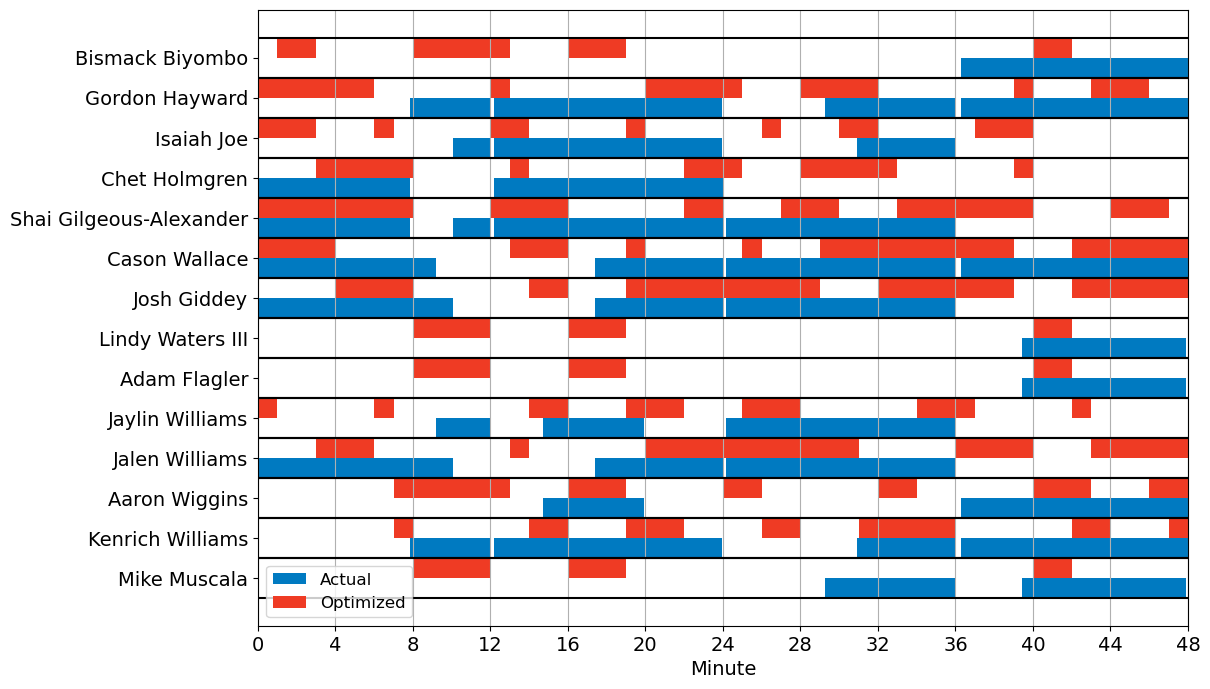

In [267]:
import matplotlib.pyplot as plt

# Assuming nba_players_dict is defined and contains player_id to player_name mapping

def plot_gantt_chart(actual_stints, optimized_slots):
    fig, ax = plt.subplots(figsize=(12, 8))
    player_positions = {nba_players_dict[player_id]: idx for idx, player_id in enumerate(set(actual_stints.keys()).union(optimized_slots.keys()))}

    # Plot actual minutes
    for player_id, stints_list in actual_stints.items():
        for period, start_seconds, duration in stints_list:
            start_time = (period - 1) * 12 * 60 + (12 * 60 - start_seconds)
            ax.broken_barh([(start_time / 60, duration / 60)], (player_positions[nba_players_dict[player_id]] - 0.5, 0.5), facecolors='#007ac1', label='Actual' if player_id == list(actual_stints.keys())[0] else "")

    # Plot optimized minutes
    for player, time_slots in optimized_slots.items():
        time_slots.sort()
        start = time_slots[0]
        for i in range(1, len(time_slots)):
            if time_slots[i] != time_slots[i - 1] + 1:
                ax.broken_barh([(start, time_slots[i - 1] - start + 1)], (player_positions[nba_players_dict[player]], 0.5), facecolors='#ef3b24', label='Optimized' if player == list(optimized_slots.keys())[0] else "")
                start = time_slots[i]
        ax.broken_barh([(start, time_slots[-1] - start + 1)], (player_positions[nba_players_dict[player]], 0.5), facecolors='#ef3b24', label='Optimized' if player == list(optimized_slots.keys())[0] else "")

    # Add borders or gridlines for each player
    # for player_name, position in player_positions.items():
    #     ax.axhline(y=position - 0.5, color='gray', linestyle='--', linewidth=1.5)
    #     ax.axhline(y=position + 0.5, color='gray', linestyle='--', linewidth=1.5)
        
    for player_name, position in player_positions.items():
        ax.axhline(y=position - 0.5, color='black', linewidth=1.5)
        ax.axhline(y=position + 0.5, color='black', linewidth=1.5)


    # Customize the plot
    ax.set_xlabel('Minute', fontsize=14)
    # ax.set_ylabel('Player Name', fontsize=12)
    ax.set_yticks(list(player_positions.values()))
    ax.set_yticklabels(list(player_positions.keys()))
    ax.set_xticks(range(0, 49, 4))
    ax.set_xlim(0, 48)
    ax.grid(True, axis='x')  # Only show vertical gridlines

    # Add legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='lower left', fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=14)
    
    plt.show()

# Plot Gantt charts for home and away teams
plot_gantt_chart(home_stints, home_optimized_slots)
# plot_gantt_chart(away_stints, away_optimized_slots, 'Away Team Player Stints (Actual vs Optimized)')

In [229]:
# Calculate total minutes played for each player
player_minutes = {}
for players in all_sim_results_df[all_sim_results_df['game_id']==game_to_run]['players']:
    for player in players:
        player_minutes[player] = player_minutes.get(player, 0) + 1

game_minutes = player_box_stats[player_box_stats['game'] == game_to_run]
mpg_dict = dict(zip(game_minutes['player_id'], game_minutes['min']))

# Step 3: Create a DataFrame for player minutes and compare with MPG
player_minutes_df = pd.DataFrame([
    {'player_id': player, 'minutes_played': minutes, 'mpg': mpg_dict.get(player, 0)}
    for player, minutes in player_minutes.items()
])

player_minutes_df['difference'] = player_minutes_df['minutes_played'] - player_minutes_df['mpg']
player_minutes_df['player_name'] = player_minutes_df['player_id'].map(nba_players_dict)
player_minutes_df

,player_id,minutes_played,mpg,difference,player_name
0,1628984,21,20.550000,0.450000,Devonte' Graham
1,1630572,26,25.516667,0.483333,Sandro Mamukelashvili
2,1630577,25,24.133333,0.866667,Julian Champagnie
3,1631104,26,25.266667,0.733333,Blake Wesley
4,1631321,29,28.283333,0.716667,Sidy Cissoko
5,1628380,27,26.216667,0.783333,Zach Collins
6,1630200,28,27.683333,0.316667,Tre Jones
7,1631103,20,19.800000,0.200000,Malaki Branham
8,1630561,18,18.000000,0.000000,David Duke Jr.
9,1630564,13,12.550000,0.450000,RaiQuan Gray


In [237]:
# Very rare how many players and minutes played OKC had, how rare was it?
# Identify unique game/team combinations
unique_game_teams = player_box_stats[['game', 'team_id']].drop_duplicates()

# Filter players with at least 8 minutes
df_filtered = player_box_stats[player_box_stats['min'] >= 8]

# Count unique players per game/team combination
player_counts = df_filtered.groupby(['game', 'team_id'])['player_id'].nunique().reset_index(name='player_count')

# Merge with unique game/team combinations to ensure all combinations are considered
merged = unique_game_teams.merge(player_counts, on=['game', 'team_id'], how='left').fillna(0)

# Determine the percentage of game/team combinations with at least 14 players meeting the criterion
total_combos = len(unique_game_teams)
combos_with_14_players = len(merged[merged['player_count'] >= 14])
percentage = (combos_with_14_players / total_combos) * 100

print(f"Percentage of game/team combos with at least 14 players playing 8+ minutes: {percentage:.2f}%")

Percentage of game/team combos with at least 14 players playing 8+ minutes: 0.03%


In [238]:
total_combos

61056

In [239]:
combos_with_14_players

19

In [240]:
# Filter players with at least 8 minutes
df_filtered = player_box_stats[player_box_stats['min'] >= 8]

# Count unique players per game/team combination
player_counts = df_filtered.groupby(['game', 'team_id'])['player_id'].nunique().reset_index(name='player_count')

# Identify game/team combinations with at least 14 players playing 8+ minutes
games_with_14_players = player_counts[player_counts['player_count'] >= 14]

In [241]:
games_with_14_players

,game,team_id,player_count
47890,0022000031,1610612742,14
48306,0022000242,1610612744,14
48322,0022000250,1610612738,14
49646,0022000918,1610612755,14
50013,0022100023,1610612760,14
50214,0022100126,1610612763,14
50370,0022100205,1610612745,14
50531,0022100285,1610612763,15
50567,0022100303,1610612763,14
51919,0022100990,1610612762,14
